In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE, SequentialFeatureSelector, VarianceThreshold, SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import warnings

In [2]:
df = pd.read_csv(r"C:\Users\jason\Downloads\College_Data_Mod.csv")
#Removing the data for Cazenovia College, which had a reported graduation rate of 118%
df.drop(95, axis=0, inplace=True)
#Removing the data for Rutgers at new Brunswik (Outlier for Apps)
df.drop(483, axis=0, inplace=True)
#Removing the data for University of Minnesota at Twin Cities (Outlier for part_Undergrad)
df.drop(640, axis=0, inplace=True)
#Renaming some of the variables
df.rename(columns={'F.Undergrad' : 'full_Undergrad', 'P.Undergrad' : 'part_Undergrad', 'Room.Board' : 'RoomBoard', 'S.F.Ratio' : 'sfRatio', 'perc.alumni' : 'perc_alumni', 'Grad.Rate' : 'GradRate'}, inplace=True)
#Create additional variable for acceptance rate, using the number of accecpted applicants and the number of total applicants
df['AcceptRate'] = (df['Accept'] / df['Apps']) * 100
#Create additional variable for enrollment rate, using the number of accepted applicants and the number of enrolled applicants
df['Enroll_Rate'] = (df['Enroll'] / df['Accept']) * 100
#Creating additional variable to combine the Top10perc and Top25perc variables. 
#On of 4.0 scale, the average GPA for someone in the top 10% of their high school class is 3.9, and the average for the top 25% is 3.7
#The difference from 4.0 was found for each of the average GPA's to determine the proper weighting for the new variable
#With that difference for the top 25% being 3 times the difference of the top 10%, the difference in the following variable have been divided by 3
df['TopOfClass'] = df['Top10perc'] + ((df['Top25perc'] - df['Top10perc']) / 3)
df.head(10)
#Private: Indication of a private(Yes = 1) or public(No = 0) university
#Apps: Number of applications received
#Accept: Number of applications accepted
#Enroll: Number of accecpted applicants who enrolled
#Top10perc: Percentage of new students who were in the top 10% of the High School Class
#Top25perc: Percentage of new students who were in the top 25% of the High School Class
#full_Undergrad: Number of full-time undergraduate students
#part_Undergrad: Number of part-time undergraduate students
#Outstate: Out of state tuition
#RoomBoard: Room and board costs
#Books: Estimated cost of books
#Personal: Estimated personal Spending
#PhD: Percentage of faculty with a PhD
#Terminal: Percentage of faculty with a terminal degree (Highest level availiable in the field)
#sfRatio: Student/Faculty Ratio
#perc_alumni: Percentage of alumni who donate
#Expend: Instuctional expenditure per student
#GradRate: Garduation Rate
#AcceptRate: Acceptance rate, from applications accepted / applications received
#Enroll_Rate: The percentage of students who enrolled of those who got accepted
#TopOfClass: A comblined percentage of enrolled students who can from the upper percentges of their high school class
#Note: AcceptRate, Enroll_Rate and TopOfClass were not included in the original data set, they were was added on afterwards
#Note: Top10perc and Top25perc were removed from the dataset, as they were consolidated into TopOfClass

College Name Private  Apps  Accept  Enroll  Top10perc  \
0  Abilene Christian University     Yes  1660    1232     721         23   
1            Adelphi University     Yes  2186    1924     512         16   
2                Adrian College     Yes  1428    1097     336         22   
3           Agnes Scott College     Yes   417     349     137         60   
4     Alaska Pacific University     Yes   193     146      55         16   
5             Albertson College     Yes   587     479     158         38   
6       Albertus Magnus College     Yes   353     340     103         17   
7                Albion College     Yes  1899    1720     489         37   
8              Albright College     Yes  1038     839     227         30   
9     Alderson-Broaddus College     Yes   582     498     172         21   

   Top25perc  full_Undergrad  part_Undergrad  Outstate  ...  Personal  PhD  \
0         52            2885             537      7440  ...      2200   70   
1         29            2683            1227     12280  ...      1500   29   
2         50            1036              99     11250  ...      1165   53   
3         89             510              63     12960  ...       875   92   
4         44             249             869      7560  ...      1500   76   
5         62             678              41     13500  ...       675   67   
6         45             416             230     13290  ...      1500   90   
7         68            1594              32     13868  ...       850   89   
8         63             973             306     15595  ...       500   79   
9         44             799              78     10468  ...      1800   40   

   Terminal  sfRatio  perc_alumni  Expend  GradRate  AcceptRate  Enroll_Rate  \
0        78     18.1           12    7041        60   74.216867    58.522727   
1        30     12.2           16   10527        56   88.014639    26.611227   
2        66     12.9           30    8735        54   76.820728    30.628988   
3        97      7.7           37   19016        59   83.693046    39.255014   
4        72     11.9            2   10922        15   75.647668    37.671233   
5        73      9.4           11    9727        55   81.601363    32.985386   
6        93     11.5           26    8861        63   96.317280    30.294118   
7       100     13.7           37   11487        73   90.573986    28.430233   
8        84     11.3           23   11644        80   80.828516    27.056019   
9        41     11.5           15    8991        52   85.567010    34.538153   

   TopOfClass  
0   32.666667  
1   20.333333  
2   31.333333  
3   69.666667  
4   25.333333  
5   46.000000  
6   26.333333  
7   47.333333  
8   41.000000  
9   28.666667  

[10 rows x 22 columns]

In [3]:
#Run this cell twice to clear the warning that pops up
#Modifying the dataset to make it useable for calculations:
#Create dummy variables for whether or not a school is private
df['Private'].replace(['Yes', 'No'],[1,0], inplace=True)
#Drop 'College Name' to make the data frame usable for calculations
mod_df = df.drop('College Name', axis=1, inplace=False)
#Dropping both 'Top10perc' and 'Top25perc' in favor of just having 'TopOfClass' to decrease multicolinearity
mod_df.drop('Top10perc', axis=1, inplace=True)
mod_df.drop('Top25perc', axis=1, inplace=True)
warnings.simplefilter("ignore", category=FutureWarning)
mod_df.head(10)

C:\Users\jason\AppData\Local\Temp\ipykernel_6696\816649005.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Private'].replace(['Yes', 'No'],[1,0], inplace=True)
C:\Users\jason\AppData\Local\Temp\ipykernel_6696\816649005.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Private'].replace

Private  Apps  Accept  Enroll  full_Undergrad  part_Undergrad  Outstate  \
0        1  1660    1232     721            2885             537      7440   
1        1  2186    1924     512            2683            1227     12280   
2        1  1428    1097     336            1036              99     11250   
3        1   417     349     137             510              63     12960   
4        1   193     146      55             249             869      7560   
5        1   587     479     158             678              41     13500   
6        1   353     340     103             416             230     13290   
7        1  1899    1720     489            1594              32     13868   
8        1  1038     839     227             973             306     15595   
9        1   582     498     172             799              78     10468   

   RoomBoard  Books  Personal  PhD  Terminal  sfRatio  perc_alumni  Expend  \
0       3300    450      2200   70        78     18.1           12    7041   
1       6450    750      1500   29        30     12.2           16   10527   
2       3750    400      1165   53        66     12.9           30    8735   
3       5450    450       875   92        97      7.7           37   19016   
4       4120    800      1500   76        72     11.9            2   10922   
5       3335    500       675   67        73      9.4           11    9727   
6       5720    500      1500   90        93     11.5           26    8861   
7       4826    450       850   89       100     13.7           37   11487   
8       4400    300       500   79        84     11.3           23   11644   
9       3380    660      1800   40        41     11.5           15    8991   

   GradRate  AcceptRate  Enroll_Rate  TopOfClass  
0        60   74.216867    58.522727   32.666667  
1        56   88.014639    26.611227   20.333333  
2        54   76.820728    30.628988   31.333333  
3        59   83.693046    39.255014   69.666667  
4        15   75.647668    37.671233   25.333333  
5        55   81.601363    32.985386   46.000000  
6        63   96.317280    30.294118   26.333333  
7        73   90.573986    28.430233   47.333333  
8        80   80.828516    27.056019   41.000000  
9        52   85.567010    34.538153   28.666667

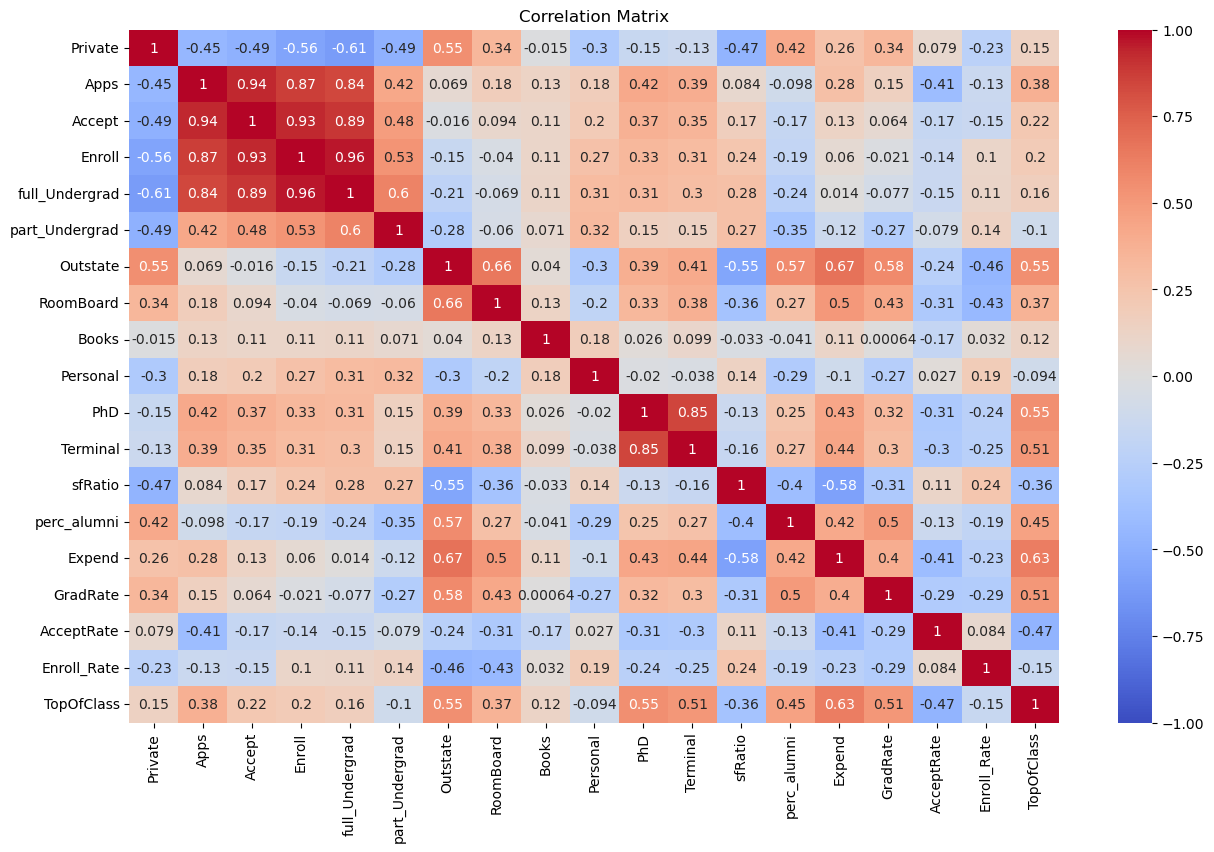

In [4]:
#Correlation Matrix of the data
plt.figure(figsize= (15,9))
sns.heatmap(mod_df.corr(), annot= True , cmap = "coolwarm", vmin=-1, vmax= 1)
plt.title("Correlation Matrix")
plt.show()

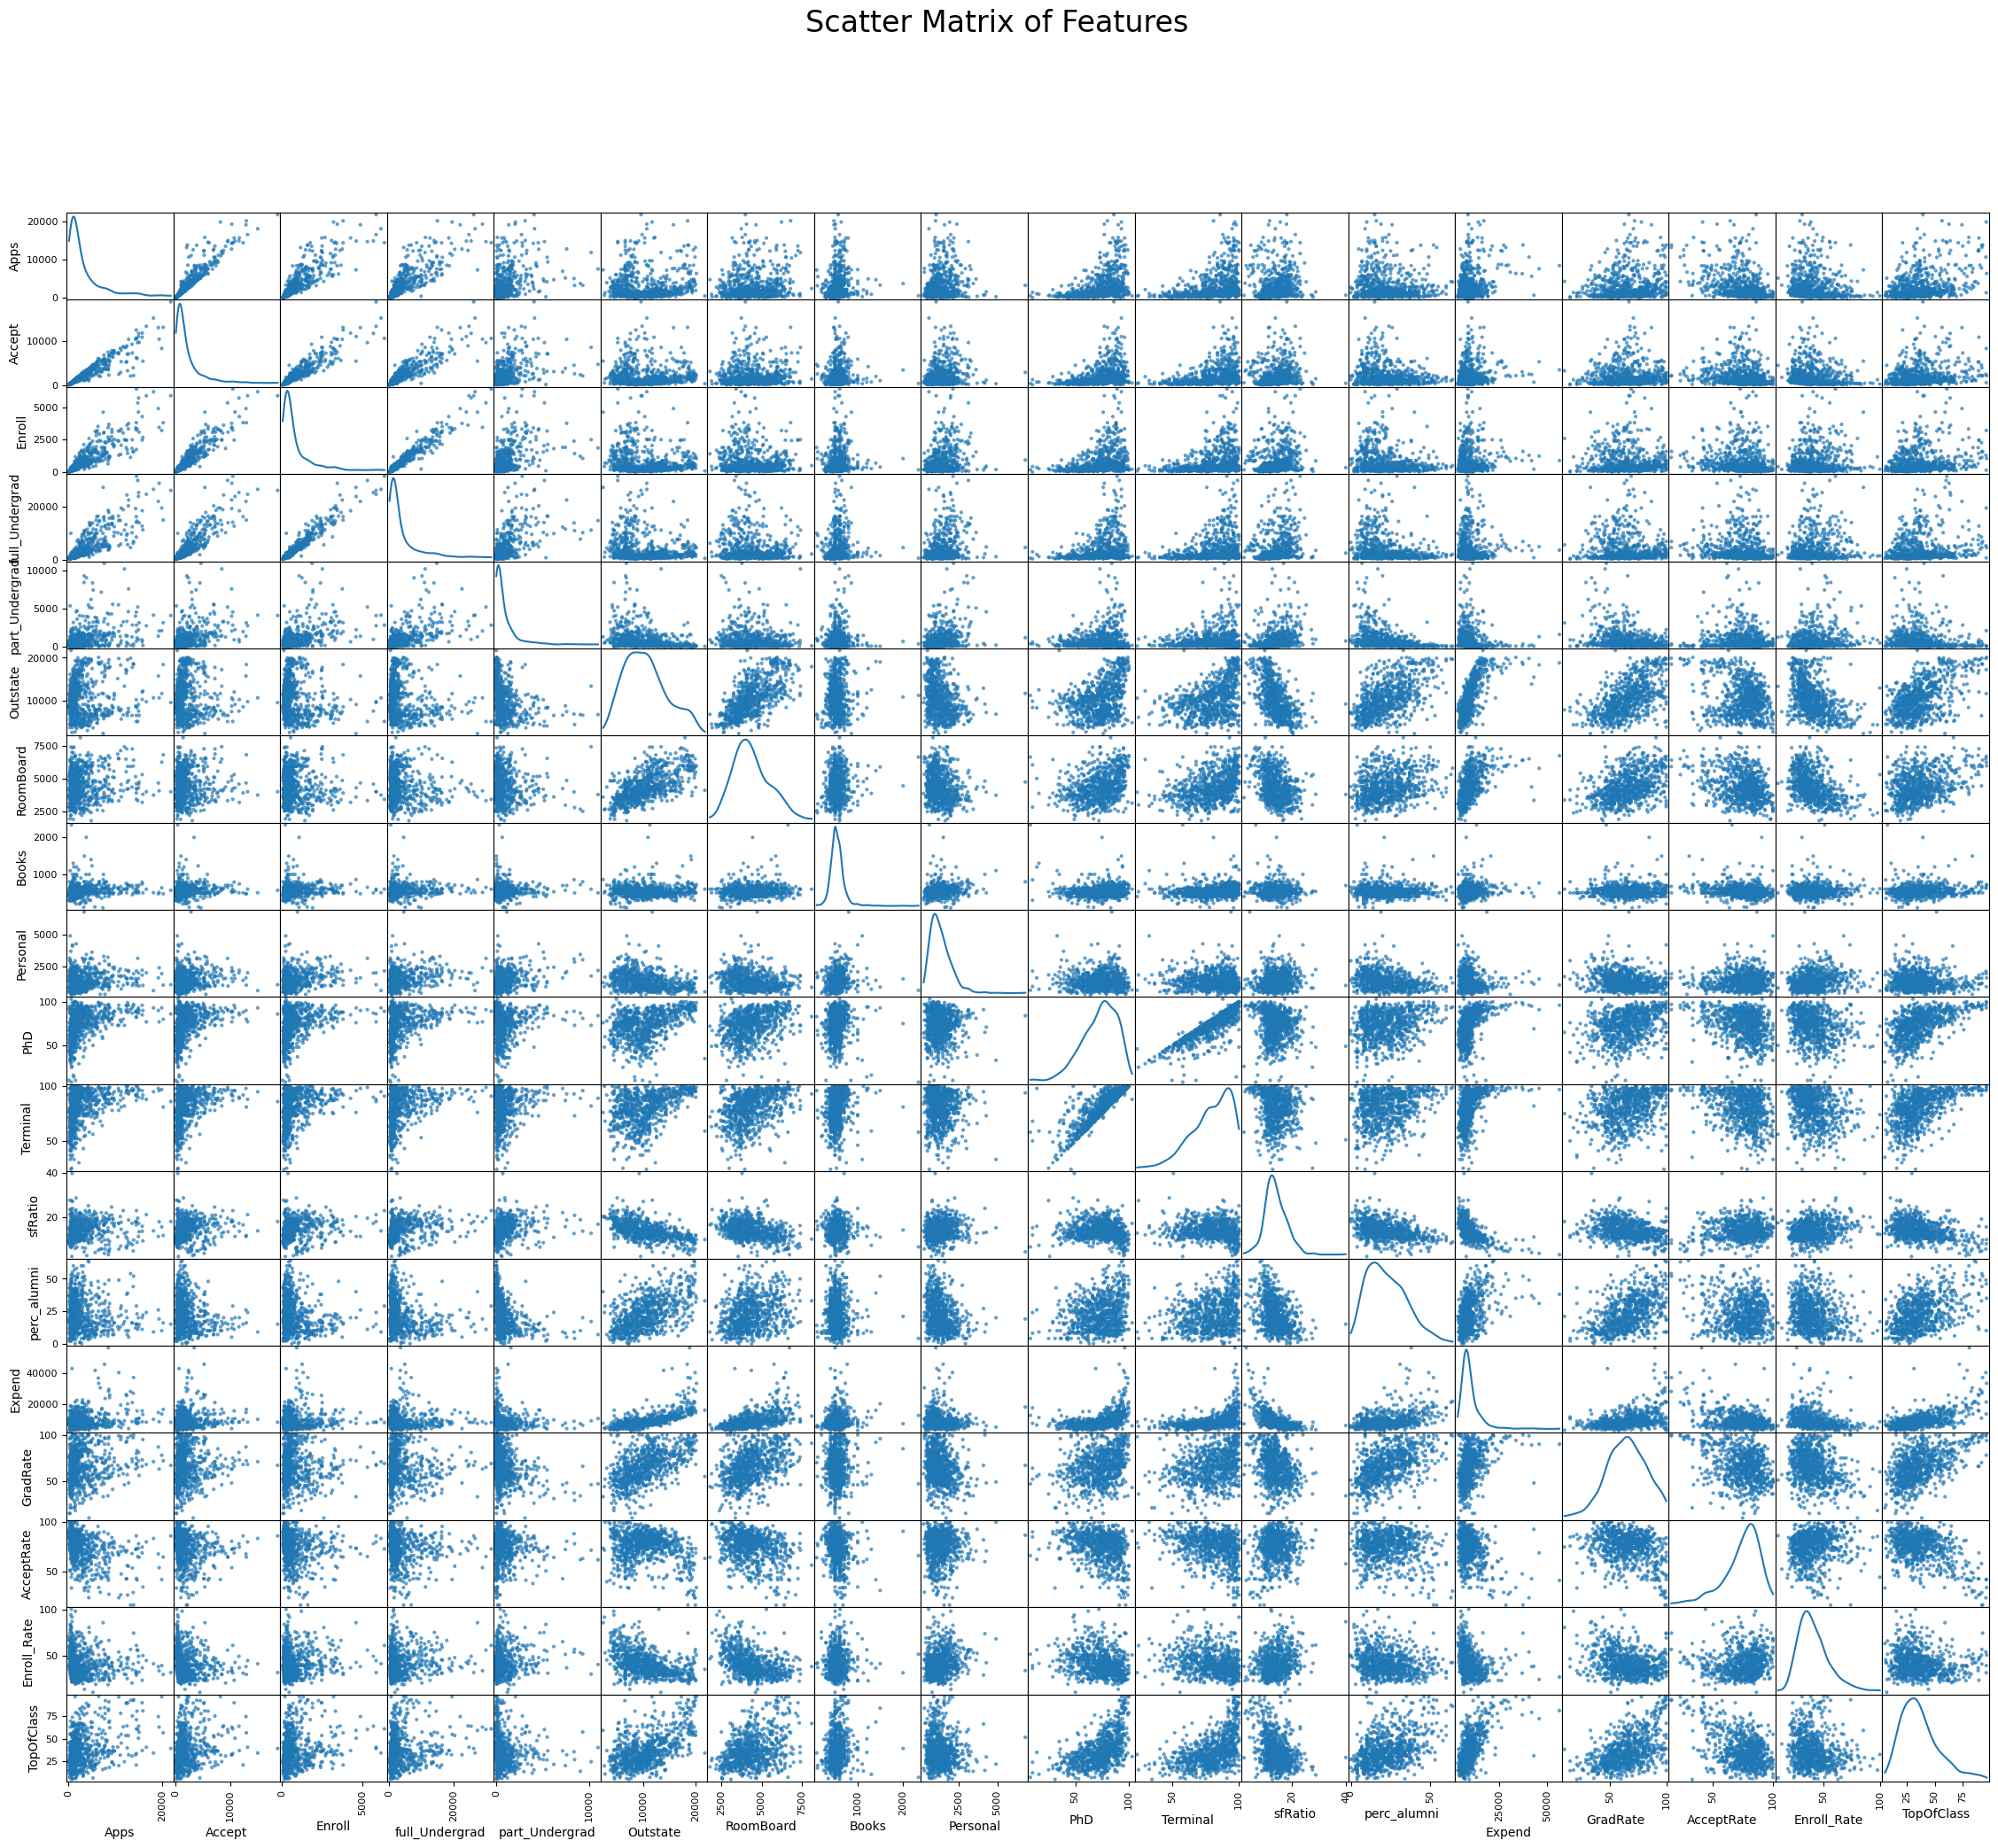

In [5]:
#Scatter plot matrix to observe relationships
pd.plotting.scatter_matrix(mod_df.drop('Private', axis=1, inplace=False), figsize=(28, 23), diagonal="kde", alpha=0.7)
plt.suptitle("Scatter Matrix of Features", fontsize=24)
plt.show()

In [6]:
#Calculating the VIF scores for all predictor variables
vif_data = pd.DataFrame()
X = mod_df.drop('GradRate', axis=1, inplace=False)
vif_data["Feature"] = X.columns
vif_data["VIF"] = [ variance_inflation_factor(X.values, i) for i in range(X.shape[1] )]
#Sorting data in ascending order to for the bar graph
vif_data.sort_values(by=['VIF'], ascending=True, inplace = True)
vif_data

Feature         VIF
5   part_Undergrad    2.674551
9         Personal    6.229339
13     perc_alumni    7.968422
0          Private    9.955889
14          Expend   13.026468
8            Books   13.107907
17      TopOfClass   14.262464
16     Enroll_Rate   19.944055
12         sfRatio   20.453656
4   full_Undergrad   29.494171
1             Apps   30.523227
7        RoomBoard   32.935421
6         Outstate   33.724983
15      AcceptRate   39.107191
3           Enroll   48.941579
2           Accept   51.884084
10             PhD   85.725536
11        Terminal  115.524876

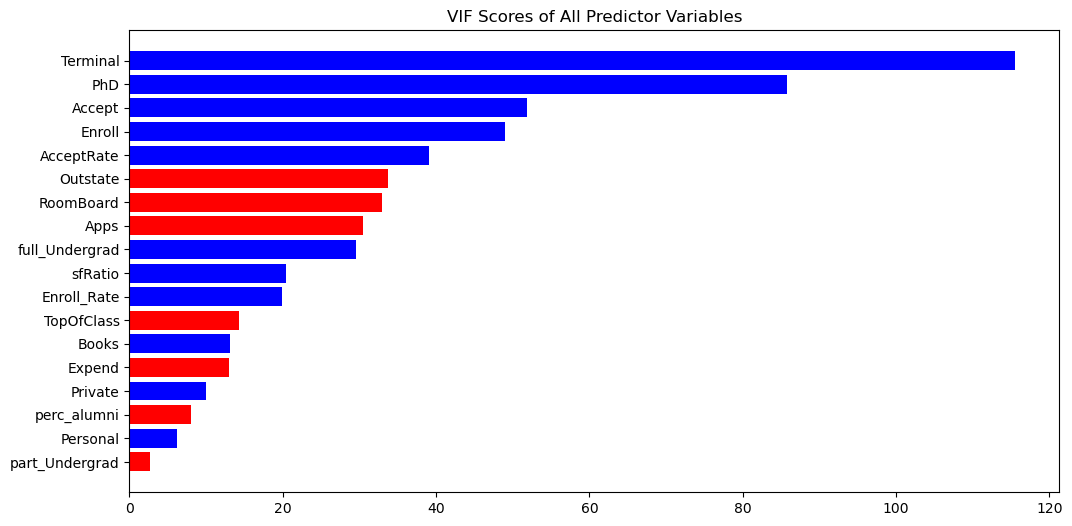

In [7]:
#VIF data visualization:
#Important Features in red
colors = ['red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'blue', 'blue']
fig, ax = plt.subplots(figsize = (12, 6))
ax.barh(vif_data['Feature'], vif_data['VIF'], color=colors)
ax.set_title('VIF Scores of All Predictor Variables')
plt.show()

In [8]:
#Determining the appropriate type of model for the data (Linear Regression or Decision Trees)
y = df['GradRate']
# Standardize features and target
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
y_standardized = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y_standardized, test_size=0.2, random_state=0)

# Initializing the linear regression model with standardized data
lr_model = LinearRegression()
# Training the linear regression model with standardized data
lr_model.fit(X_train, y_train)
# Making Prediction with the linear regression model using standardized data
y_pred_lr = lr_model.predict(X_test)

# Decision Tree model with normalized data
dt_model = DecisionTreeRegressor(random_state=0)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# Evaluation metrics for regression
metrics = {
    'Mean Absolute Error': [mean_absolute_error(y_test, y_pred_lr), mean_absolute_error(y_test, y_pred_dt)],
    'Mean Squared Error': [mean_squared_error(y_test, y_pred_lr), mean_squared_error(y_test, y_pred_dt)],
    'Root Mean Squared Error': [np.sqrt(mean_squared_error(y_test, y_pred_lr)), np.sqrt(mean_squared_error(y_test, y_pred_dt))],
    'R2 Score': [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_dt)],
    'Mean Absolute Percentage Error': [mean_absolute_percentage_error(y_test, y_pred_lr), mean_absolute_percentage_error(y_test, y_pred_dt)]
}
# Store regression metrics in a DataFrame
results_df = pd.DataFrame(metrics, index=['Linear Regression', 'Decision Tree'])
results_df

Mean Absolute Error  Mean Squared Error  \
Linear Regression             0.568821            0.587623   
Decision Tree                 0.773062            1.049504   

                   Root Mean Squared Error  R2 Score  \
Linear Regression                 0.766566  0.446278   
Decision Tree                     1.024453  0.011045   

                   Mean Absolute Percentage Error  
Linear Regression                        1.801081  
Decision Tree                            2.579933

In [9]:
#Feature selection for the linear regression model
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(mod_df.drop("GradRate", axis=1), mod_df["GradRate"], test_size=0.2, random_state=42)

# Dictionary to store selected features
selected_features = {}

#Feature Selection through Varience Threshold
selector_variance = VarianceThreshold(threshold=0.1)
selector_variance.fit(X_train)
selected_features['Variance Threshold'] = X_train.columns[selector_variance.get_support()].tolist()

#Feature Selection through Correlation
correlation_matrix = X_train.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
selected_features['Correlation'] = X_train.columns.difference(high_corr_features).tolist()

#5 predictor variables resulted in the best model when features were selected by Statistical Testing
selector_kbest = SelectKBest(score_func=f_regression, k=5)
selector_kbest.fit(X_train, y_train)
selected_features['Statistical Test (SelectKBest)'] = X_train.columns[selector_kbest.get_support()].tolist()

#After multiple tests, 7 predictor variables resulted in the best model
#A cv value of 500 is being used because it resulted in the most accurate model, the dataset is small enough so using a cv value that high only takes about a minute to run
lr_model = LinearRegression()
forward_selector = SequentialFeatureSelector(lr_model, n_features_to_select=7, direction='forward', scoring='neg_mean_squared_error', cv=500)
forward_selector.fit(X_train, y_train)
selected_features['Forward Selection (Linear Regression)'] = X_train.columns[forward_selector.get_support()].tolist()

#Feature Selection through decision tree regression
dt_model = DecisionTreeRegressor()
rfe_selector = RFE(dt_model, n_features_to_select=10)
rfe_selector.fit(X_train, y_train)
selected_features['RFE (Decision Tree Regressor)'] = X_train.columns[rfe_selector.get_support()].tolist()

selected_features_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in selected_features.items()]))
selected_features_df

Variance Threshold     Correlation Statistical Test (SelectKBest)  \
0             Private      AcceptRate                       Outstate   
1                Apps            Apps                      RoomBoard   
2              Accept           Books                    perc_alumni   
3              Enroll     Enroll_Rate                         Expend   
4      full_Undergrad          Expend                     TopOfClass   
5      part_Undergrad        Outstate                            NaN   
6            Outstate        Personal                            NaN   
7           RoomBoard             PhD                            NaN   
8               Books         Private                            NaN   
9            Personal       RoomBoard                            NaN   
10                PhD        Terminal                            NaN   
11           Terminal      TopOfClass                            NaN   
12            sfRatio  part_Undergrad                            NaN   
13        perc_alumni     perc_alumni                            NaN   
14             Expend         sfRatio                            NaN   
15         AcceptRate             NaN                            NaN   
16        Enroll_Rate             NaN                            NaN   
17         TopOfClass             NaN                            NaN   

   Forward Selection (Linear Regression) RFE (Decision Tree Regressor)  
0                         part_Undergrad                full_Undergrad  
1                               Outstate                part_Undergrad  
2                              RoomBoard                      Outstate  
3                            perc_alumni                     RoomBoard  
4                                 Expend                      Personal  
5                             AcceptRate                   perc_alumni  
6                             TopOfClass                        Expend  
7                                    NaN                    AcceptRate  
8                                    NaN                   Enroll_Rate  
9                                    NaN                    TopOfClass  
10                                   NaN                           NaN  
11                                   NaN                           NaN  
12                                   NaN                           NaN  
13                                   NaN                           NaN  
14                                   NaN                           NaN  
15                                   NaN                           NaN  
16                                   NaN                           NaN  
17                                   NaN                           NaN

In [10]:
#Testing different models using the different selected features from above
#Model based on Varience Threshold (Includes all predictor variables)
y = mod_df['GradRate']
X1 = mod_df.drop('GradRate', axis = 1, inplace=False)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.2, random_state=42)
model_summary1 = smf.ols(formula= "y ~ X1", data = mod_df)
result1 = model_summary1.fit()
model1 = LinearRegression()
model1.fit(X_train1, y_train1)
y_pred1 = model1.predict(X_test1)
r2_1 = r2_score(y_test1, y_pred1)
mse1 = mean_squared_error(y_test1, y_pred1)
mae1 = mean_absolute_error(y_test1, y_pred1)
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     37.89
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           9.18e-93
Time:                        14:55:53   Log-Likelihood:                -3045.5
No. Observations:                 774   AIC:                             6129.
Df Residuals:                     755   BIC:                             6217.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.9730      7.018      6.551      0.000      32.196      59.750
X1[0]          4.1962      1.685      2.490      0.013       0.888       7.504
X1[1]          0.0006      0.001      1.056      0.291      -0.001       0.002
X1[2]          0.0010      0.001      0.943      0.346      -0.001       0.003
X1[3]       2.075e-05      0.003      0.008      0.994      -0.005       0.005
X1[4]         -0.0003      0.000     -0.801      0.423      -0.001       0.000
X1[5]         -0.0018      0.000     -3.887      0.000      -0.003      -0.001
X1[6]          0.0010      0.000      4.150      0.000       0.001       0.001
X1[7]          0.0016      0.001      2.712      0.007       0.000       0.003
X1[8]         -0.0035      0.003     -1.191      0.234      -0.009       0.002
X1[9]         -0.0013      0.001     -1.756      0.079      -0.003       0.000
X1[10]         0.0996      0.056      1.773      0.077      -0.011       0.210
X1[11]        -0.0621      0.061     -1.019      0.309      -0.182       0.058
X1[12]         0.0331      0.158      0.210      0.834      -0.277       0.343
X1[13]         0.2873      0.049      5.825      0.000       0.190       0.384
X1[14]        -0.0006      0.000     -3.762      0.000      -0.001      -0.000
X1[15]        -0.1274      0.048     -2.653      0.008      -0.222      -0.033
X1[16]         0.0165      0.050      0.330      0.741      -0.081       0.114
X1[17]         0.1821      0.041      4.398      0.000       0.101       0.263
==============================================================================
Omnibus:                       25.631   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.209
Skew:                           0.077   Prob(JB):                     8.43e-14
Kurtosis:                       4.358   Cond. No.                     2.64e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
#Model based on Correlation
y = mod_df['GradRate']
X2 = mod_df[['AcceptRate', 'Apps', 'Books', 'Enroll_Rate', 'Expend', 'Outstate', 'part_Undergrad', 'Personal', 'Private', 'RoomBoard', 'sfRatio', 'Terminal', 'TopOfClass', 'perc_alumni']].copy()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=42)
model_summary2 = smf.ols(formula= "y ~ X2", data = mod_df)
result2 = model_summary2.fit()
model2 = LinearRegression()
model2.fit(X_train2, y_train2)
y_pred2 = model2.predict(X_test2)
r2_2 = r2_score(y_test2, y_pred2)
mse2 = mean_squared_error(y_test2, y_pred2)
mae2 = mean_absolute_error(y_test2, y_pred2)
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     48.28
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           5.27e-95
Time:                        14:55:53   Log-Likelihood:                -3048.1
No. Observations:                 774   AIC:                             6126.
Df Residuals:                     759   BIC:                             6196.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.2065      6.459      7.154      0.000      33.527      58.886
X2[0]         -0.1105      0.038     -2.920      0.004      -0.185      -0.036
X2[1]          0.0009      0.000      4.828      0.000       0.001       0.001
X2[2]         -0.0040      0.003     -1.406      0.160      -0.010       0.002
X2[3]         -0.0103      0.041     -0.252      0.801      -0.090       0.070
X2[4]         -0.0006      0.000     -3.810      0.000      -0.001      -0.000
X2[5]          0.0010      0.000      4.498      0.000       0.001       0.001
X2[6]         -0.0019      0.000     -4.420      0.000      -0.003      -0.001
X2[7]         -0.0014      0.001     -1.860      0.063      -0.003    7.76e-05
X2[8]          4.0572      1.657      2.449      0.015       0.805       7.309
X2[9]          0.0016      0.001      2.705      0.007       0.000       0.003
X2[10]         0.0517      0.157      0.329      0.742      -0.256       0.360
X2[11]         0.0164      0.042      0.393      0.695      -0.065       0.098
X2[12]         0.1890      0.040      4.740      0.000       0.111       0.267
X2[13]         0.2811      0.049      5.777      0.000       0.186       0.377
==============================================================================
Omnibus:                       25.995   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.786
Skew:                           0.090   Prob(JB):                     6.32e-14
Kurtosis:                       4.361   Cond. No.                     2.35e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
#Model based on Statistical Tests
y = mod_df['GradRate']
X3 = mod_df[['Outstate', 'RoomBoard', 'perc_alumni', 'Expend', 'TopOfClass']].copy()
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.2, random_state=42)
model_summary3 = smf.ols(formula= "y ~ X3", data = mod_df)
result3 = model_summary3.fit()
model3 = LinearRegression()
model3.fit(X_train3, y_train3)
y_pred3 = model3.predict(X_test3)
r2_3 = r2_score(y_test3, y_pred3)
mse3 = mean_squared_error(y_test3, y_pred3)
mae3 = mean_absolute_error(y_test3, y_pred3)
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     115.7
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           3.94e-91
Time:                        14:55:53   Log-Likelihood:                -3077.3
No. Observations:                 774   AIC:                             6167.
Df Residuals:                     768   BIC:                             6195.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.4855      1.986     15.350      0.000      26.587      34.384
X3[0]          0.0013      0.000      6.476      0.000       0.001       0.002
X3[1]          0.0021      0.001      3.631      0.000       0.001       0.003
X3[2]          0.3017      0.047      6.389      0.000       0.209       0.394
X3[3]         -0.0005      0.000     -3.633      0.000      -0.001      -0.000
X3[4]          0.2706      0.035      7.726      0.000       0.202       0.339
==============================================================================
Omnibus:                       21.243   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.005
Skew:                           0.163   Prob(JB):                     3.39e-09
Kurtosis:                       4.050   Cond. No.                     6.83e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
#Model based on Forward Selection
y = mod_df['GradRate']
X4 = mod_df[['Apps', 'part_Undergrad', 'Outstate', 'perc_alumni', 'TopOfClass', 'Expend', 'RoomBoard']].copy()
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y, test_size=0.2, random_state=42)
model_summary4 = smf.ols(formula= "y ~ X4", data = mod_df)
result4 = model_summary4.fit()
model4 = LinearRegression()
model4.fit(X_train4, y_train4)
y_pred4 = model4.predict(X_test4)
r2_4 = r2_score(y_test4, y_pred4)
mse4 = mean_squared_error(y_test4, y_pred4)
mae4 = mean_absolute_error(y_test4, y_pred4)
result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     92.00
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           4.04e-97
Time:                        14:55:53   Log-Likelihood:                -3058.4
No. Observations:                 774   AIC:                             6133.
Df Residuals:                     766   BIC:                             6170.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.2862      2.014     16.526      0.000      29.332      37.240
X4[0]          0.0008      0.000      4.946      0.000       0.001       0.001
X4[1]         -0.0023      0.000     -5.476      0.000      -0.003      -0.001
X4[2]          0.0013      0.000      6.155      0.000       0.001       0.002
X4[3]          0.3023      0.048      6.271      0.000       0.208       0.397
X4[4]          0.2114      0.037      5.695      0.000       0.139       0.284
X4[5]         -0.0006      0.000     -4.217      0.000      -0.001      -0.000
X4[6]          0.0021      0.001      3.732      0.000       0.001       0.003
==============================================================================
Omnibus:                       29.464   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.028
Skew:                           0.204   Prob(JB):                     3.40e-14
Kurtosis:                       4.326   Cond. No.                     7.23e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
#Model based on Decision Tree Regression
y = mod_df['GradRate']
X5 = mod_df[['Outstate', 'Personal', 'perc_alumni', 'AcceptRate', 'Enroll_Rate', 'full_Undergrad', 'Expend', 'Terminal', 'Apps', 'TopOfClass']].copy()
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y, test_size=0.2, random_state=42)
model_summary5 = smf.ols(formula= "y ~ X5", data = mod_df)
result5 = model_summary5.fit()
model5 = LinearRegression()
model5.fit(X_train5, y_train5)
y_pred5 = model5.predict(X_test5)
r2_5 = r2_score(y_test5, y_pred5)
mse5 = mean_squared_error(y_test5, y_pred5)
mae5 = mean_absolute_error(y_test5, y_pred5)
result5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     62.76
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           1.34e-92
Time:                        14:55:53   Log-Likelihood:                -3062.3
No. Observations:                 774   AIC:                             6147.
Df Residuals:                     763   BIC:                             6198.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     49.8862      5.397      9.243      0.000      39.291      60.481
X5[0]          0.0014      0.000      7.207      0.000       0.001       0.002
X5[1]         -0.0020      0.001     -2.601      0.009      -0.003      -0.000
X5[2]          0.3099      0.048      6.410      0.000       0.215       0.405
X5[3]         -0.0755      0.040     -1.886      0.060      -0.154       0.003
X5[4]         -0.0235      0.042     -0.554      0.580      -0.107       0.060
X5[5]         -0.0007      0.000     -2.842      0.005      -0.001      -0.000
X5[6]         -0.0006      0.000     -4.146      0.000      -0.001      -0.000
X5[7]         -0.0143      0.040     -0.356      0.722      -0.093       0.065
X5[8]          0.0013      0.000      3.816      0.000       0.001       0.002
X5[9]          0.2137      0.040      5.388      0.000       0.136       0.292
==============================================================================
Omnibus:                       25.446   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.211
Skew:                           0.124   Prob(JB):                     6.22e-13
Kurtosis:                       4.297   Cond. No.                     1.91e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.91e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
#Table to view the R-Squared values and errors
model_data = {'Feature Selection Method' : ['Varience Threshold', 'Correlation', 'Statistical Test', 'Forward Selection', 'Decision Tree Regression'], 'R-Squared' : [r2_1, r2_2, r2_3, r2_4, r2_5], 'MSE' : [mse1, mse2, mse3, mse4, mse5], 'MAE' : [mae1, mae2, mae3, mae4, mae5]}
model_analysis = pd.DataFrame(model_data)
model_analysis

Feature Selection Method  R-Squared         MSE       MAE
0        Varience Threshold   0.515243  145.707618  8.851026
1               Correlation   0.523363  143.266922  8.787038
2          Statistical Test   0.497934  150.910608  9.395734
3         Forward Selection   0.544205  137.002380  8.695088
4  Decision Tree Regression   0.519756  144.351180  9.073869

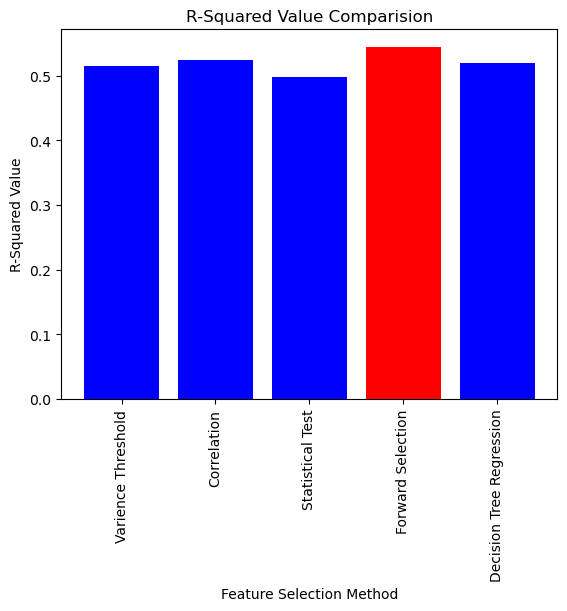

In [16]:
#Bar chart to compare R-Squared values
colors = ['blue', 'blue', 'blue', 'red', 'blue']
plt.bar(model_data['Feature Selection Method'], model_data['R-Squared'], color=colors)
plt.xticks(rotation=90)
plt.xlabel('Feature Selection Method')
plt.ylabel('R-Squared Value')
plt.title('R-Squared Value Comparision')
plt.show()

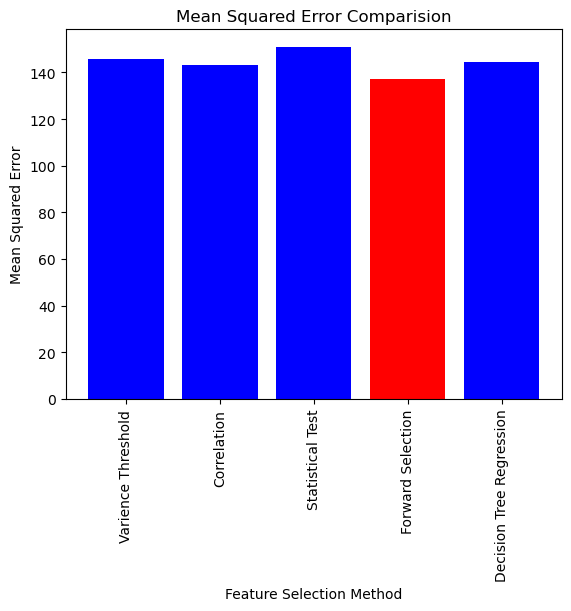

In [17]:
#Bar chart to compare Mean Squared errors values
colors = ['blue', 'blue', 'blue', 'red', 'blue']
plt.bar(model_data['Feature Selection Method'], model_data['MSE'], color=colors)
plt.xticks(rotation=90)
plt.xlabel('Feature Selection Method')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error Comparision')
plt.show()

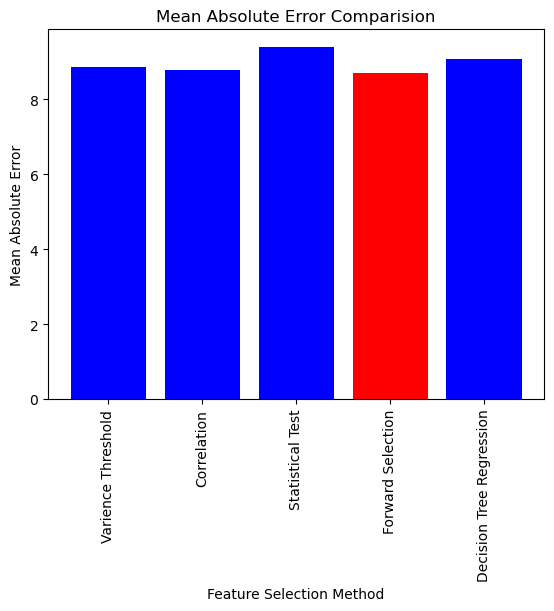

In [18]:
#Bar chart to compare Mean Absolute Error values
colors = ['blue', 'blue', 'blue', 'red', 'blue']
plt.bar(model_data['Feature Selection Method'], model_data['MAE'], color=colors)
plt.xticks(rotation=90)
plt.xlabel('Feature Selection Method')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error Comparision')
plt.show()

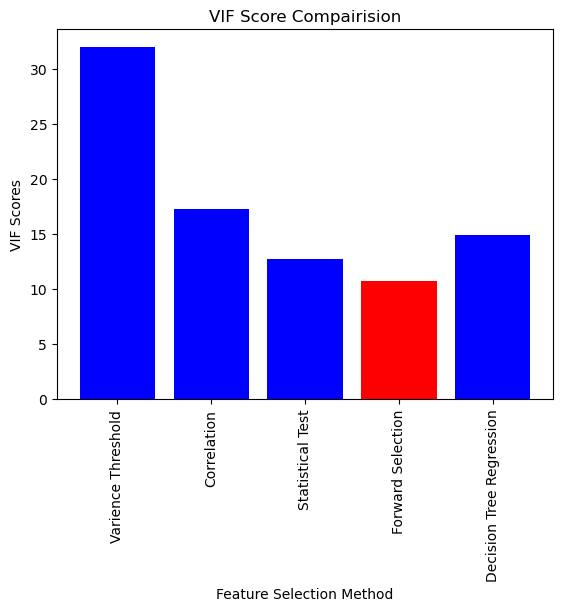

In [19]:
#VIF average for model 1
vif_data1 = pd.DataFrame()
vif_data1["VIF"] = [ variance_inflation_factor(X1.values, i) for i in range(X1.shape[1] )]
vif_mean1 = vif_data1['VIF'].mean()

#VIF average for model 2
vif_data2 = pd.DataFrame()
vif_data2["VIF"] = [ variance_inflation_factor(X2.values, i) for i in range(X2.shape[1] )]
vif_mean2 = vif_data2['VIF'].mean()

#VIF average for model 3
vif_data3 = pd.DataFrame()
vif_data3["VIF"] = [ variance_inflation_factor(X3.values, i) for i in range(X3.shape[1] )]
vif_mean3 = vif_data3['VIF'].mean()

#VIF average for model 4
vif_data4 = pd.DataFrame()
vif_data4["VIF"] = [ variance_inflation_factor(X4.values, i) for i in range(X4.shape[1] )]
vif_mean4 = vif_data4['VIF'].mean()

#VIF average for model 5
vif_data5 = pd.DataFrame()
vif_data5["VIF"] = [ variance_inflation_factor(X5.values, i) for i in range(X5.shape[1] )]
vif_mean5 = vif_data5['VIF'].mean()

VIF_Scores = [vif_mean1, vif_mean2, vif_mean3, vif_mean4, vif_mean5,]

#Bar chart to compare the average VIF score for all of the predictor variables within each model
colors = ['blue', 'blue', 'blue', 'red', 'blue']
plt.bar(model_data['Feature Selection Method'], VIF_Scores, color=colors)
plt.xticks(rotation=90)
plt.xlabel('Feature Selection Method')
plt.ylabel('VIF Scores')
plt.title('VIF Score Compairision')
plt.show()

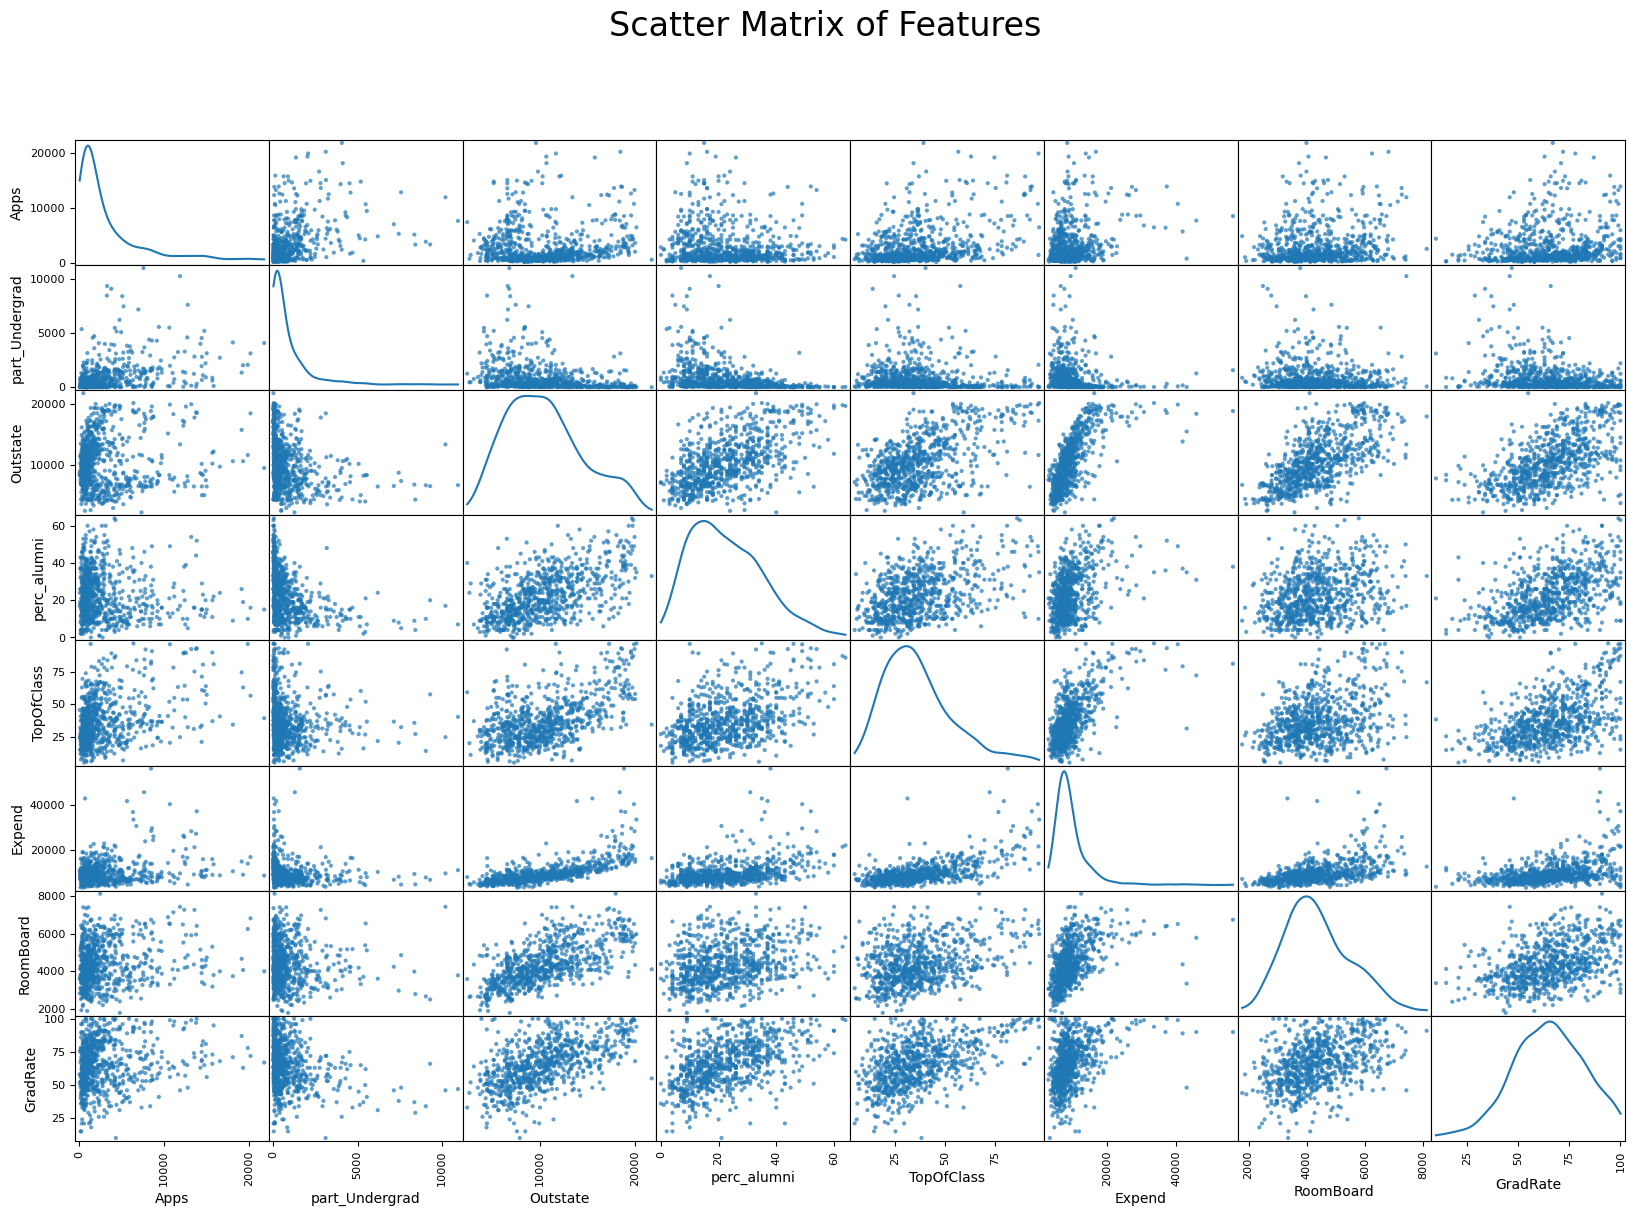

In [20]:
#Scatter plot matrix of  important features
important_features = X4
important_features['GradRate'] = mod_df['GradRate']
pd.plotting.scatter_matrix(important_features, figsize=(20, 13), diagonal="kde", alpha=0.7)
plt.suptitle("Scatter Matrix of Features", fontsize=24)
plt.show()